In [104]:
import numpy as np
import matplotlib.pyplot as plt
%pylab inline
import access_spectrum as acs
import run_empca
reload(run_empca)
from run_empca import *
import polyfit as pf
silent=False
# Remember, the windows are the INVERSE of the absorption features

Populating the interactive namespace from numpy and matplotlib


In [105]:
windowinfo = 'pickles/windowinfo.pkl'
elemwindows,window_all,window_peak,windowPeaks,windowPixels,tophats = acs.pklread(windowinfo)

In [106]:
specs = acs.pklread('red_clump/pickles/spectra_FE_H_u-0.4_d-0.5.pkl')[0]

In [107]:
errs = acs.pklread('red_clump/pickles/errs_FE_H_u-0.4_d-0.5.pkl')

In [123]:
def make_specs(specs,errs,elemlist,proportion=None):
    SNR = specs/errs
    vec = np.zeros(aspcappix)
    for ind in range(len(elemlist)):
        if not proportion:
            vec += elemwindows[elemlist[ind]]
        elif proportion:
            vec += elemwindows[elem[ind]]*proportion[ind]
    newspecs = np.ma.masked_array(np.tile(vec,(specs.shape[0],1)),specs.mask)
    noise = newspecs/SNR
    drawn_noise = noise*np.random.randn(noise.shape[0],noise.shape[1])
    newspecs += drawn_noise
    newspecs.mask[np.where(noise<1e-10)] = True
    noise.mask[np.where(noise<1e-10)] = True
    return newspecs,noise
def vec_weight(elem,vec):
    w = elemwindows[elem]
    nw = np.ma.masked_array(pf.normweights(w))
    return np.ma.sum(nw*vec)
    
def arr_weight(elem,arr):
    w = elemwindows[elem]
    nw = np.ma.masked_array(pf.normweights(w))
    nws = np.tile(nw,(arr.shape[0],1))
    return np.ma.sum(nws*arr,axis=1)
    
def test_run(specs,noise,deltR2=2e-3,nvecs=5,mad=True,maxvec=5):
    m1,m2,w1,w2 = pix_empca(None,specs.T,noise,'test.pkl',nvecs=nvecs,deltR2=2e-3,gen=True,usemad=mad)
    R2_1 = R2(m1) #must be here (and not below resize) to avoid error
    R2_2 = R2(m2)
    R2_noise2 = R2noise(w2,m2,usemad=mad)
    resize_pix_eigvecs(specs.T,m1,nstars=5)
    resize_pix_eigvecs(specs.T,m2,nstars=5)
    m1elem = np.zeros((nvecs,len(elems)))
    m2elem = np.zeros((nvecs,len(elems)))
    specs_weight = np.ma.masked_array(np.zeros((len(elems),specs.shape[0])))
    noise_weight = np.ma.masked_array(np.zeros((len(elems),specs.shape[0])))
    for ind in range(len(elems)):
        specs_weight[ind] = arr_weight(elems[ind],specs)
        noise_weight[ind] = arr_weight(elems[ind],noise)
        for vec in range(nvecs):
            m1elem[vec][ind] = vec_weight(elems[ind],m1.eigvec[vec])
            m2elem[vec][ind] = vec_weight(elems[ind],m2.eigvec[vec])
    specs_weight.mask[np.where(noise_weight<1e-10)] = True
    noise_weight.mask[np.where(noise_weight<1e-10)] = True
    m3,m4,w3,w4 = elem_empca(None,specs_weight,noise_weight,'test2.pkl',nvecs=nvecs,gen=True,deltR2=2e-3,usemad=mad)        
    R2_3 = R2(m3)
    R2_4 = R2(m4)
    R2_noise4 = R2noise(w4,m4,usemad=mad)
    resize_pix_eigvecs(specs_weight,m3,nstars=5,dim2=len(elems))
    resize_pix_eigvecs(specs_weight,m4,nstars=5,dim2=len(elems))
    for n in range(maxvec):
        plt.figure(figsize=(12,3))
        plt.axhline(0,linestyle='--',color='k',linewidth=3)
        plt.plot(norm_eigvec(m1elem[n]),'o',markersize=8)
        plt.plot(norm_eigvec(m2elem[n]),'o',markersize=8)
        plt.plot(norm_eigvec(m3.eigvec[n]),'o',markersize=8)
        plt.plot(norm_eigvec(m4.eigvec[n]),'o',markersize=8)
        plt.xticks(range(len(elems)),elems)
        plt.ylabel('Eigenvenctor {0}'.format(n+1))
        plt.xlim(-1,len(elems)+1)
    plt.figure(figsize=(12,3))
    plt.plot(R2_1,marker='o',linewidth = 3,markersize=8)
    plt.plot(R2_2,marker='o',linewidth = 3,markersize=8)
    plt.axhline(R2_noise2,linestyle='--',color='b',linewidth=3,label='R2n_pix = {0:2f}'.format(R2_noise2))
    plt.fill_between(range(nvecs+1),R2_noise2,1,color='b',alpha=0.2)
    plt.plot(R2_3,marker='o',linewidth = 3,markersize=8)
    plt.plot(R2_4,marker='o',linewidth = 3,markersize=8)
    plt.axhline(R2_noise4,linestyle='--',color='r',linewidth=3,label='R2n_elem = {0:2f}'.format(R2_noise4))
    plt.fill_between(range(nvecs+1),R2_noise4,1,color='r',alpha=0.2)
    plt.legend(loc='best')
    
    

In [122]:
falsespecs,noise = make_specs(specs,errs,['C','Al'])

       iter        R2             rchi2
EMPCA  1/25       0.00000117  27154.51347065
R2: 0.999985991587
var, Vnoise  0.0179481474845 2.09926680663e-06
       iter        R2             rchi2
EMPCA  1/25    -889.42232974 -78492467561843.96875000
EMPCA  2/25       0.92612203 -49636650506.72059631
EMPCA  3/25       0.99999294 -2268495556.73139858
EMPCA  4/25       1.00000000   -825.25042033
R2: 1.0
var, Vnoise  1.26316789687e-05 3.98692249941e-07


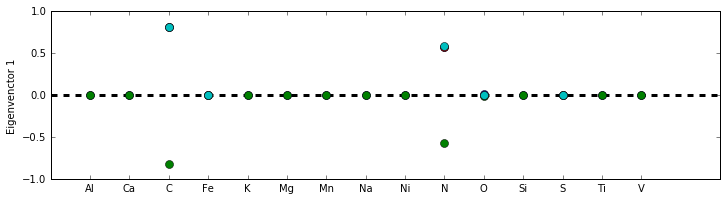

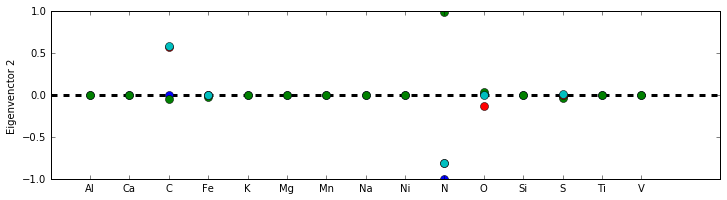

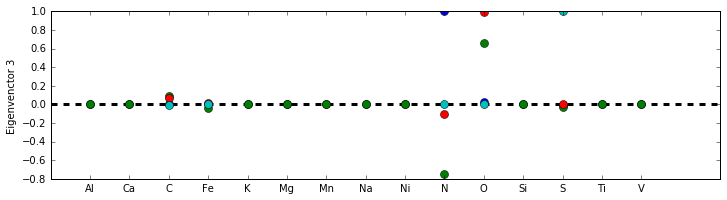

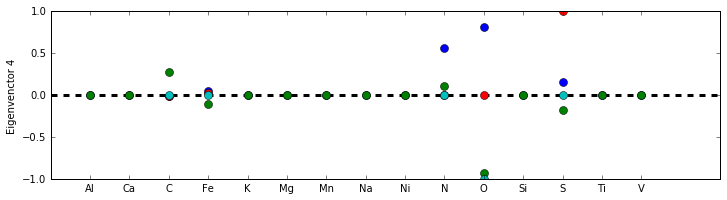

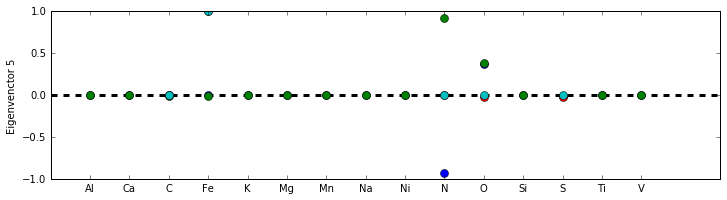

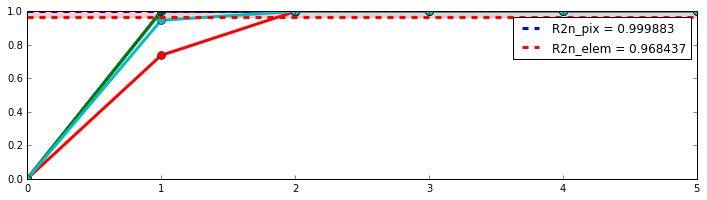

In [124]:
test_run(falsespecs,noise)